In [1]:
# Import libs

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.stats import chi2, t

from sklearn.metrics import r2_score, mean_squared_error

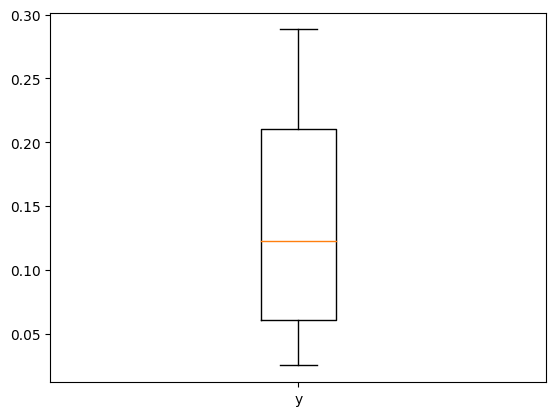

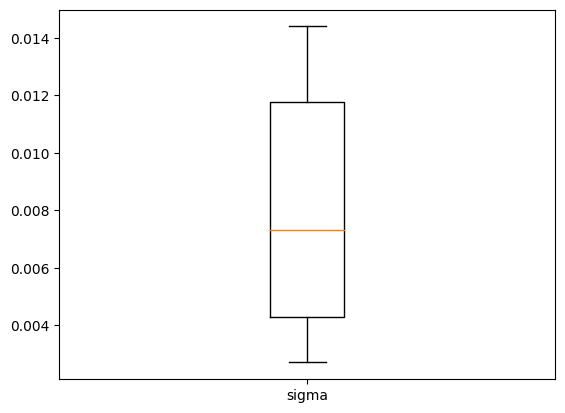

In [2]:
# Grab data from .txt file

with open('data3.txt', 'r') as f:
    data = np.loadtxt(f)


# Show box plots
for i, s in zip(range(data.shape[1]), ('y', 'sigma')):
    plt.boxplot(data[:, i + 1], labels = (s,))
    plt.show()


x = data[:, 0]
y = data[:, 1]
sigma = data[:, 2]

In [3]:
# Define function that will calculate chi square criteria and make
# decision of null hypothesis rejection with alpha significance level

def Chi_square_statistics(x, y, sigma, func, alpha, args):
    residuals = (func(x, *args) - y) / sigma
    chi = np.sum(residuals ** 2)

    df = len(x) - len(args)
    p_value = 1 - chi2.cdf(chi, df)

    if p_value < alpha:
        print("Reject the null hypothesis: there is statistically significant evidence in favor of the alternative hypothesis.")
    else:
        print("Accept the null hypothesis: there is no statistically significant evidence against it.")

    return chi / df, p_value


alpha = 0.05

In [4]:
# Calculate weighted residuals

def Weighted_residuals_calculate(x, y, sigma, func, args):
    residuals = (y - func(x, *args)) / sigma

    return residuals

In [63]:
# Calculate weighted residuals autocorrelation

def Autocorrelation(x, y, sigma, func, args):
    residuals = Weighted_residuals_calculate(x, y, sigma, func, args)

    N = len(x)
    k = N // 2
    A = np.zeros(k)

    residuals_squared_sum = np.sum(residuals ** 2)
    
    for i in range(k):
        s1 = 0
        for j in range(N - k):
            s1 += residuals[j] * residuals[j + i]
        
        A[i] = (1 / (N - i) * s1) / (residuals_squared_sum / N)

    return A

In [6]:
# Calculate confidence intervals base on t-Student distribution

def Confidence_intervals(res, df, confidence_level):
    diag = np.sqrt(np.diag(res[1]))

    confidence_intervals = res[0] + t.ppf(confidence_level / 2, df) * diag, res[0] + t.ppf(1 - confidence_level / 2, df) * diag

    print("Estimated parameters:\n", res[0])
    print("Confidence intervals:\n", confidence_intervals)

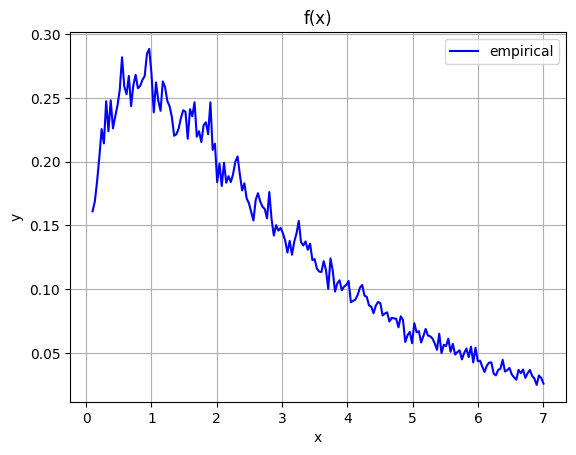

In [12]:
# Show original data

plt.plot(x, y, label = 'empirical', c = 'b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x)')
plt.legend()
plt.grid(True)
plt.show()

(array([1.43985305, 1.76480724]), array([[ 0.00223854, -0.0003252 ],
       [-0.0003252 ,  0.00109546]]))


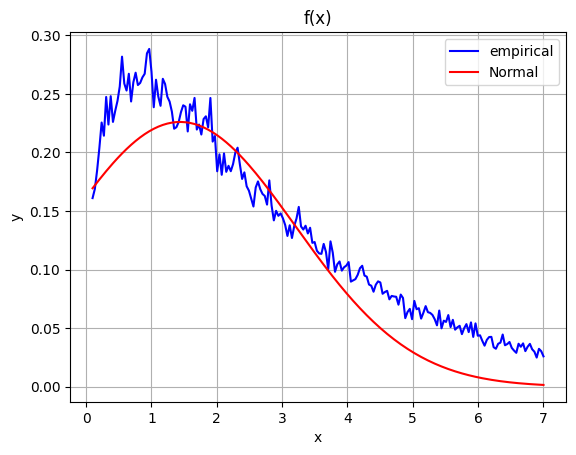

Reject the null hypothesis: there is statistically significant evidence in favor of the alternative hypothesis.
Normal chi-square statistics: 38.34017887558718, p-value = 0.0


Normal R2-score: 0.8431653025647178
Normal MSE: 0.000975162815198949


In [8]:
# Try normal distribution as non-linear function

def Normal(x, m, sigma):
    return 1 / (sigma * (2 * np.pi) ** 0.5) * np.exp(-1 * (x - m) ** 2 / (2 * sigma ** 2))


# Fit model
normal_res = curve_fit(Normal, x, y)

print(normal_res)

# Show how good normal distribution describes data
plt.plot(x, y, label = 'empirical', c = 'blue')
plt.plot(x, Normal(x, *normal_res[0]), label = 'Normal', c = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x)')
plt.legend()
plt.grid(True)
plt.show()

# Get chi square statistics
normal_chi_statistics = Chi_square_statistics(x, y, sigma, Normal, alpha, normal_res[0])
print(f'Normal chi-square statistics: {normal_chi_statistics[0]}, p-value = {normal_chi_statistics[1]}')

# # Show plot of weighted residuals
# normal_residuals = Weighted_residuals_calculate(x, y, sigma, Normal, normal_res[0])
# plt.plot(x, normal_residuals, label = 'Normal', c = 'red')
# plt.xlabel('x')
# plt.ylabel('Residuals')
# plt.title('Weighted residuals plot')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Show autocorrelation function of weighted residuals
# norma_autocorrelation = Autocorrelation(x, y, sigma, Normal, normal_res[0])
# plt.plot(range(len(norma_autocorrelation)), norma_autocorrelation, label = 'Normal', c = 'red')
# plt.xlabel('Num semples')
# plt.ylabel('Residuals')
# plt.title('Autocorrelation function of weighted residuals')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Calculate confidence intervals for each function param
# Confidence_intervals(normal_res, len(x) - len(normal_res[1]), 0.68)

# Get r2-score & MSE
print(f"\n\nNormal R2-score: {r2_score(y, Normal(x, *normal_res[0]))}")
print(f"Normal MSE: {mean_squared_error(y, Normal(x, *normal_res[0]))}")

(array([1.98453873]), array([[0.001754]]))


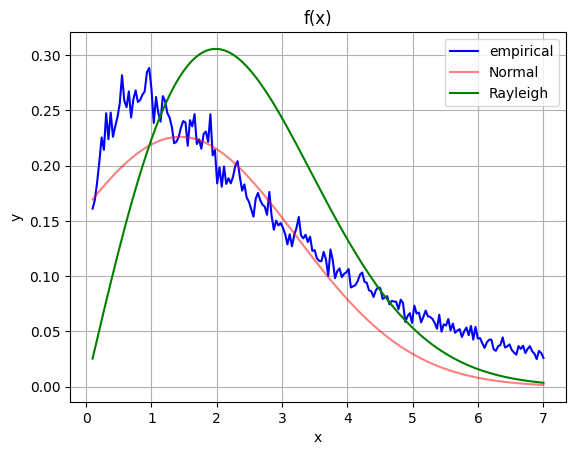

Reject the null hypothesis: there is statistically significant evidence in favor of the alternative hypothesis.
Normal chi-square statistics: 38.34017887558718, p-value = 0.0
Rayleigh chi-square statistics: 62.17565792079087, p-value = 0.0


Residuals R2-score: 0.19782785240695155
Residuals MSE: 0.004987725691528294


In [10]:
def Rayleigh(x, sigma):
    return x / (sigma ** 2) * np.exp(-1 * x ** 2 / (2 * sigma ** 2))


rayleigh_res = curve_fit(Rayleigh, x, y)

print(rayleigh_res)

plt.plot(x, y, label = 'empirical', c = 'blue')
plt.plot(x, Normal(x, *normal_res[0]), label = 'Normal', c = 'red', alpha = 0.5)
plt.plot(x, Rayleigh(x, rayleigh_res[0]), label = 'Rayleigh', c = 'g')
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x)')
plt.legend()
plt.grid(True)
plt.show()

rayleigh_chi_statistics = Chi_square_statistics(x, y, sigma, Rayleigh, alpha, rayleigh_res[0])
print(f'Normal chi-square statistics: {normal_chi_statistics[0]}, p-value = {normal_chi_statistics[1]}')
print(f'Rayleigh chi-square statistics: {rayleigh_chi_statistics[0]}, p-value = {rayleigh_chi_statistics[1]}')

# rayleigh_residuals = Weighted_residuals_calculate(x, y, sigma, Rayleigh, rayleigh_res[0])
# plt.plot(x, normal_residuals, label = 'Normal', c = 'red', alpha = 0.5)
# plt.plot(x, rayleigh_residuals, label = 'Rayleigh', c = 'g')
# plt.xlabel('x')
# plt.ylabel('Residuals')
# plt.title('Weighted residuals plot')
# plt.grid(True)
# plt.legend()
# plt.show()

# rayleigh_autocorrelation = Autocorrelation(x, y, sigma, Rayleigh, rayleigh_res[0])
# plt.plot(range(len(norma_autocorrelation)), norma_autocorrelation, label = 'Normal', c = 'red', alpha = 0.5)
# plt.plot(range(len(rayleigh_autocorrelation)), rayleigh_autocorrelation, label = 'Rayleigh', c = 'g')
# plt.xlabel('Num semples')
# plt.ylabel('Residuals')
# plt.title('Autocorrelation function of weighted residuals')
# plt.grid(True)
# plt.legend()
# plt.show()

# Confidence_intervals(rayleigh_res, len(x) - len(rayleigh_res[1]), 0.68)

print(f"\n\nResiduals R2-score: {r2_score(y, Rayleigh(x, *rayleigh_res[0]))}")
print(f"Residuals MSE: {mean_squared_error(y, Rayleigh(x, *rayleigh_res[0]))}")

(array([2.80297675]), array([[8.39035829e-05]]))


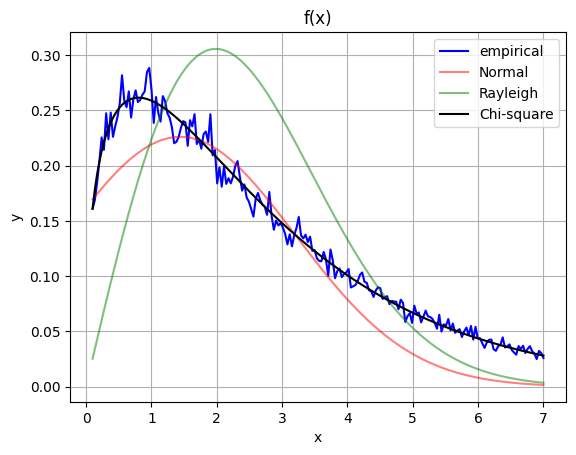

Accept the null hypothesis: there is no statistically significant evidence against it.
Normal chi-square statistics: 38.34017887558718, p-value = 0.0
Rayleigh chi-square statistics: 62.17565792079087, p-value = 0.0
Chi-square chi-square statistics: 1.1020690698561766, p-value = 0.15420309107777674


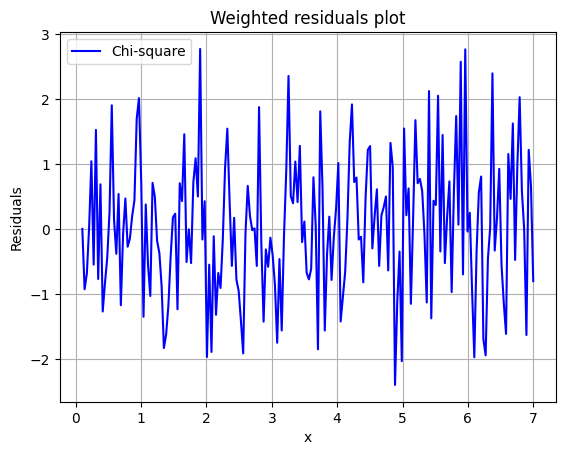

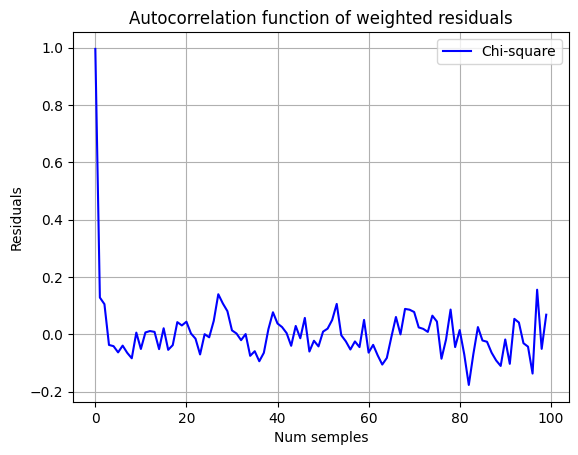

Estimated parameters:
 [2.80297675]
Confidence intervals:
 (array([2.79919307]), array([2.80676042]))


Chi-square R2-score: 0.9875708144492289
Chi-square MSE: 7.728187557043342e-05


In [64]:
def Chi_square(x, n):
    return 1 / (2 ** (n / 2) * gamma(n / 2)) * x ** (n / 2 - 1) * np.exp(-x / 2)


chi_square_res = curve_fit(Chi_square, x, y)

print(chi_square_res)

plt.plot(x, y, label = 'empirical', c = 'blue')
plt.plot(x, Normal(x, *normal_res[0]), label = 'Normal', c = 'red', alpha = 0.5)
plt.plot(x, Rayleigh(x, rayleigh_res[0]), label = 'Rayleigh', c = 'g', alpha = 0.5)
plt.plot(x, Chi_square(x, chi_square_res[0]), label = 'Chi-square', c = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x)')
plt.legend()
plt.grid(True)
plt.show()

chi_square_chi_statistics = Chi_square_statistics(x, y, sigma, Chi_square, alpha, chi_square_res[0])
print(f'Normal chi-square statistics: {normal_chi_statistics[0]}, p-value = {normal_chi_statistics[1]}')
print(f'Rayleigh chi-square statistics: {rayleigh_chi_statistics[0]}, p-value = {rayleigh_chi_statistics[1]}')
print(f'Chi-square chi-square statistics: {chi_square_chi_statistics[0]}, p-value = {chi_square_chi_statistics[1]}')

chi_square_residuals = Weighted_residuals_calculate(x, y, sigma, Chi_square, chi_square_res[0])
# plt.plot(x, normal_residuals, label = 'Normal', c = 'red', alpha = 0.5)
# plt.plot(x, rayleigh_residuals, label = 'Rayleigh', c = 'g', alpha = 0.5)
plt.plot(x, chi_square_residuals, label = 'Chi-square', c = 'b')
plt.xlabel('x')
plt.ylabel('Residuals')
plt.title('Weighted residuals plot')
plt.grid(True)
plt.legend()
plt.show()

chi_square_autocorrelation = Autocorrelation(x, y, sigma, Chi_square, chi_square_res[0])
# plt.plot(range(len(norma_autocorrelation)), norma_autocorrelation, label = 'Normal', c = 'red', alpha = 0.5)
# plt.plot(range(len(rayleigh_autocorrelation)), rayleigh_autocorrelation, label = 'Rayleigh', c = 'g', alpha = 0.5)
plt.plot(range(len(chi_square_autocorrelation)), chi_square_autocorrelation, label = 'Chi-square', c = 'b')
plt.xlabel('Num semples')
plt.ylabel('Residuals')
plt.title('Autocorrelation function of weighted residuals')
plt.grid(True)
plt.legend()
plt.show()

Confidence_intervals(chi_square_res, len(x) - len(chi_square_res[1]), 0.68)

print(f"\n\nChi-square R2-score: {r2_score(y, Chi_square(x, *chi_square_res[0]))}")
print(f"Chi-square MSE: {mean_squared_error(y, Chi_square(x, *chi_square_res[0]))}")

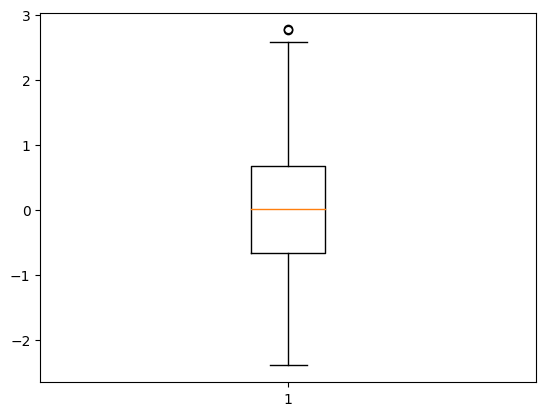

In [16]:
plt.boxplot(chi_square_residuals)
plt.show()